# Designing neuronal networks

## Overview

This notebook provides a guide to specyfing neural interconnections and designing networks using Hodgkin-Huxley and NeuroDyn models in Python environment.

## Setting up the environment

Let's first import the required Python modules and model definitions:

In [20]:
import matplotlib.pyplot as plt
from cb_models import HHModel, NeuroDynModel, NeuronalNetwork, Synapse, AMPA, AMPASynapse

# **Ignore overflow warnings**
import numpy as np
np.warnings.filterwarnings('ignore', 'overflow')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Neural interconnections

There are two main types of neural interconnections that we can implement: gap junctions and synaptic connections. In the conductance-based modelling framework, these interconnections lead to additional currents in the membrane equation of neuron $i$ that are dependent on membrane voltages of other neurons $j$ connected to it:

\begin{equation}
C \dot{V}_i = - I_{int,i} - \sum_{j} I_{gap, i, j} - \sum_{j} I_{syn, i, j} + I_{app}
\end{equation}

### Gap junctions

Gap junctions are modeled as simple resistive connections between neurons, so that a resistive connection between neurons $i$ and $j$ leads to a current in neuron $i$:

\begin{equation}
I_{gap, i, j} = g_{gap, i, j} (V_i - V_j)
\end{equation}

Since these interconnections are symmetric $g_{gap, i, j} = g_{gap, j, i}$, so that:

\begin{equation}
I_{gap, j, i} = -I_{gap, i, j}
\end{equation}

We can represent this as a matrix $G_{gap}$ where each element $g_{gap, i, j}$ is the conductance of the connection between neurons $i$ and $j$. This matrix is necessarily symmetric, i.e. $G_{gap} = G^T_{gap}$.

### Synaptic connections

Unlike gap junctions, synaptic connections are directed connections and are not symmetric: the activity of the *presynaptic* neuron (neuron $j$) modulates the activity of the *postsynaptic* neuron (neuron $i$). Synaptic currents have a similar form to the internal ionic currents, with the difference that their activation depends on the presynaptic neuron:

\begin{equation}
I_{syn, i, j} = \bar{g}_{syn, i, j} r (V_i - E_{syn}) \\
\dot{r} = \alpha_r(V_j) (1 - r) - \beta_r{V_i} r
\end{equation}

The opening of the channels $\alpha_r$ depends on the presynaptic neuron's voltage $V_j$, while the closing depends on the postsynaptic neuron's voltage $V_i$ (sometimes this relationship is modeled as constant).

The reversal potential of the synapse $E_{syn}$ determines if the synapse is *excitatory* or *inhibitory*: excitatory synapses tend to increase the postsynaptic neuron's voltage, while the inhibitory synapses act to decrease the postynaptic voltage. On the other hand, dynamics of activation $r$ determines the timescale of the synaptic current, i.e. how fast it activates in relation to the changes in the presynaptic neuron.

## Defining neural interconnections in Python

Let's now see how we can define these interconnections in the Python environment. We start with a simple example of two Hodgkin-Huxley neurons, which define as before:

In [3]:
neuron1 = HHModel()
neuron2 = HHModel()

### Gap junctions

Let's start with a simple network consisting of a single gap junction between these two neurons with $g_{gap} = 0.1$. We do this by defining the matrix `G_gap` and passing it as a keyword argument along with a list of the neurons to our `NeuronalNetwork` class:

In [10]:
neurons = [neuron1, neuron2]
G_gap = [[0, 0.1], [0.1, 0]]

network = NeuronalNetwork(neurons, gap = G_gap)

We simulate the network exactly as before by calling the method `simulate`. This time, the applied current function needs to return an array of external currents corresponding to each neuron in the `neurons` list. Additionally, we need to make sure that the initial condition array `x0` has the right number of states:

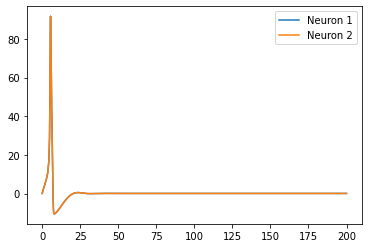

In [19]:
# Simulation time
T = 200
trange = (0, T)

# External current
I1 = 0 # current to neuron 1
I2 = 0 # current to neuron 2
Iapp = lambda t: [I1, I2]

# Initial condition
x0 = [0, 0, 0, 0] * 2

# Simulate
sol = network.simulate(trange, x0, Iapp)
V1 = sol.y[0]
V2 = sol.y[4]

plt.figure()
plt.plot(sol.t, V1, label = "Neuron 1")
plt.plot(sol.t, V2, label = "Neuron 2")
plt.legend()
plt.show()


### Synaptic connections

Let's now see how we can introduce a synapse from neuron 1 to neuron 2. We first need to create an object for the synapse of the `Synapse` class which takes three arguments: `gsyn` - maximal conductance, `Esyn` - reversal potential, `r` - gating variable object.

The `r` gating variable should derived from the class `HHKinetics` and provides methods `alpha` and `beta` that define the functions $\alpha_r(V)$ and $\beta_r(V)$.

#### AMPA synapse

As an example, let's take a look at implementing an excitatory AMPA synapse. There is an `AMPA` gating kinetics class already provided that takes the values from Ermentrout et al. 2010 that we can use here.

In [29]:
r = AMPA()
gsyn = 0.05
Esyn = 65
synapse = Synapse(gsyn, Esyn, r)

Since a synapse is defined by its reversal potential $E_{syn}$ and the gating variable kinetics $r$, we can group these steps into a single synapse object. In this case, a `AMPASynapse` class is defined that only takes a single argument $g_{syn}$ and does the same steps as previously:

In [30]:
synapse = AMPASynapse(gsyn)

Having defined the model of the synapse that we would like to use, we now need to define the connectivity matrix describing all of the synaptic connections in the network. For this, we will construct a matrix `syns` where each element of the matrix $(i, j)$ contains a list of all synaptic connections from neuron $j$ to neuron $i$. If there are no synaptic connections from neuron $j$ to neuron $i$, then we set that matrix element to `None`.

Since we would like to define a single excitatory synapse from neuron 1 to neuron 2, we will put a single AMPASynapse object into a list at position (1, 0), filling the rest of the matrix with `None`. Let's create a new network with the single excitatory synapse and simulate it:

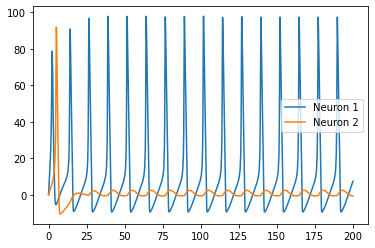

In [32]:
syns = [[None, None], [[synapse], None]]

network = NeuronalNetwork(neurons, syns = syns)

# Simulation time
T = 200
trange = (0, T)

# External current
I1 = 15 # current to neuron 1
I2 = 0 # current to neuron 2
Iapp = lambda t: [I1, I2]

# Initial condition
x0 = [0, 0, 0, 0] * 2 + [0] # extra state due to synapse

# Simulate
sol = network.simulate(trange, x0, Iapp)
V1 = sol.y[0]
V2 = sol.y[4]

plt.figure()
plt.plot(sol.t, V1, label = "Neuron 1")
plt.plot(sol.t, V2, label = "Neuron 2")
plt.legend()
plt.show()